## A custom Model
This notebook shows how to implement and train a model other than the baseline used for this challenge.

In [2]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


import torch

from utils import creating_dataset


### Load data

In [21]:
DATA_PATH = r"C:\Users\nodos\Desktop\ДИПЛОМ\Аня диплом\dataset_v2_blocks\dataset_v2_blocks"
data_paths = dict(datasets=[DATA_PATH],
                    hand_type = ['left', 'right'], # [left, 'right']
                    human_type = ['health', 'amputant'], # [amputant, 'health']
                    test_dataset_list = ['fedya_tropin_standart_elbow_left'])
data_config = creating_dataset.DataConfig(**data_paths)
train_dataset, test_dataset = creating_dataset.get_datasets(data_config, )

Getting val datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Getting train datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Number of moves: 70 | Dataset: valery_first_standart_elbow_left
Reorder this dataset valery_first_standart_elbow_left True
Number of moves: 135 | Dataset: alex_kovalev_standart_elbow_left
Reorder this dataset alex_kovalev_standart_elbow_left True
Number of moves: 72 | Dataset: anna_makarova_standart_elbow_left
Reorder this dataset anna_makarova_standart_elbow_left True
Number of moves: 62 | Dataset: artem_snailbox_standart_elbow_left
Reorder this dataset artem_snailbox_standart_elbow_left True
Number of moves: 144 | Dataset: matthew_antonov_standart_elbow_left
Reorder this dataset matthew_antonov_standart_elbow_left True
Number of moves: 144 | Dataset: misha_korobok_standart_elbow_left
Reorder this da

## Define model
We define a simple Multi Layer Perceptron, fully connected feedforward neural network with 2 hidden layers. The model is implemented using PyTorch.

In [22]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)

Try making a prediction using this model.

In [37]:

X, Y = train_dataset[0]
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

n_inputs, n_outputs = X.shape[0], Y.shape[0]
n_hidden = 64

model = MLP(n_inputs, n_hidden, n_outputs)


Y_hat = model(torch.tensor(X.T)).detach().numpy().T
print(f"Predictions shape: {Y_hat.shape}")

assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

X shape: (8, 256), Y shape: (20, 32)
Predictions shape: (20, 32)


As upi cam see. The model's predictions are of the wrong shape: the outputs are not downsampled! Remember that inputs are sampled at 200Hz, but outputs are meant to be at 25Hz. We need to downsample the outputs to match the expected shape.

You can choose your own downsampling method, but make sure that your predictions are aligned to the targets!

In [24]:
import numpy as np

def simple_downsample(x: np.ndarray) -> np.ndarray:
    return x[:, ::data_config.down_sample_target]

Y_hat = model(torch.tensor(X.T)).detach().numpy().T
Y_hat = simple_downsample(Y_hat)


assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

For simplicity, you can build the downsampling into your model

In [35]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size//2),
        #torch.nn.Dropout(p=0.1),
        torch.nn.Linear(hidden_size//2, hidden_size//4),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size//4, hidden_size//8),
        #torch.nn.Dropout(p=0.1),
        torch.nn.Linear(hidden_size//8, output_size)
    )


    def forward(self, x):
        x = self.layers(x)
        return x[::data_config.down_sample_target, :]
    

model = MLP(n_inputs, n_hidden, n_outputs)

Y_hat = model(torch.tensor(X.T)).detach().numpy().T
assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

## Training

We define a very simple training procedure.

In [36]:
n_epochs = 25
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(n_inputs, n_hidden, n_outputs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    epoch_loss = 0
    for X,Y in train_dataset:
        X, Y = torch.tensor(X.T).to(device), torch.tensor(Y).to(device)
        Y_hat = model(X).T

        loss = criterion(Y_hat, Y)
        loss.backward()
        epoch_loss += loss.item()

        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

    

KeyboardInterrupt: 

### Let's plot some predictions

In [42]:
import pandas as pd
X, Y = train_dataset[1]
pd.DataFrame(Y)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.033311,0.039512,0.044668,0.045671,0.040958,0.026323,0.007765,-0.008514,-0.014267,-0.015193,...,-0.027089,-0.025089,-0.021645,-0.015397,-0.016375,-0.014864,-0.012887,-0.012876,-0.012011,-0.015213
1,-0.062209,-0.058639,-0.051969,-0.048512,-0.045102,-0.041248,-0.037163,-0.032504,-0.025232,-0.022520,...,-0.019522,-0.024139,-0.027376,-0.029246,-0.029782,-0.030242,-0.030325,-0.029740,-0.029129,-0.027702
2,0.537800,0.541001,0.535198,0.528319,0.523395,0.520790,0.518495,0.516655,0.508253,0.505066,...,0.514687,0.518324,0.521241,0.515826,0.513978,0.512217,0.511170,0.513856,0.510625,0.509648
3,0.172076,0.177421,0.177292,0.174299,0.173638,0.175482,0.177474,0.178420,0.178860,0.179049,...,0.187709,0.194954,0.200375,0.199235,0.198659,0.198381,0.198236,0.199777,0.198423,0.198070
4,0.575798,0.560325,0.549379,0.534247,0.519633,0.509662,0.500581,0.493642,0.492431,0.489689,...,0.527762,0.533913,0.537640,0.540974,0.540966,0.539662,0.536563,0.532243,0.529543,0.525239
5,-0.008221,-0.005540,-0.003038,0.001020,0.003480,0.006425,0.009950,0.011611,0.016350,0.018331,...,0.028883,0.021468,0.017787,0.017434,0.016796,0.015982,0.016255,0.017031,0.018505,0.020720
6,0.499516,0.482092,0.479559,0.469875,0.447551,0.435259,0.427008,0.426112,0.419059,0.423865,...,0.413524,0.396005,0.392222,0.386370,0.380225,0.376670,0.374904,0.371735,0.368105,0.361803
7,0.128699,0.122447,0.122698,0.119412,0.108533,0.103314,0.102186,0.104282,0.103972,0.106425,...,0.123536,0.122955,0.124616,0.123038,0.120834,0.120368,0.120540,0.120617,0.119906,0.117032
8,0.631480,0.632745,0.631937,0.630034,0.626538,0.625509,0.627739,0.631057,0.636019,0.635442,...,0.505224,0.478442,0.471417,0.470083,0.467090,0.464724,0.463451,0.461696,0.458427,0.454614
9,0.041190,0.044384,0.044956,0.047260,0.050550,0.053020,0.054894,0.055068,0.056703,0.058581,...,0.036920,0.030844,0.029544,0.031365,0.032141,0.032282,0.033440,0.034404,0.036205,0.038563


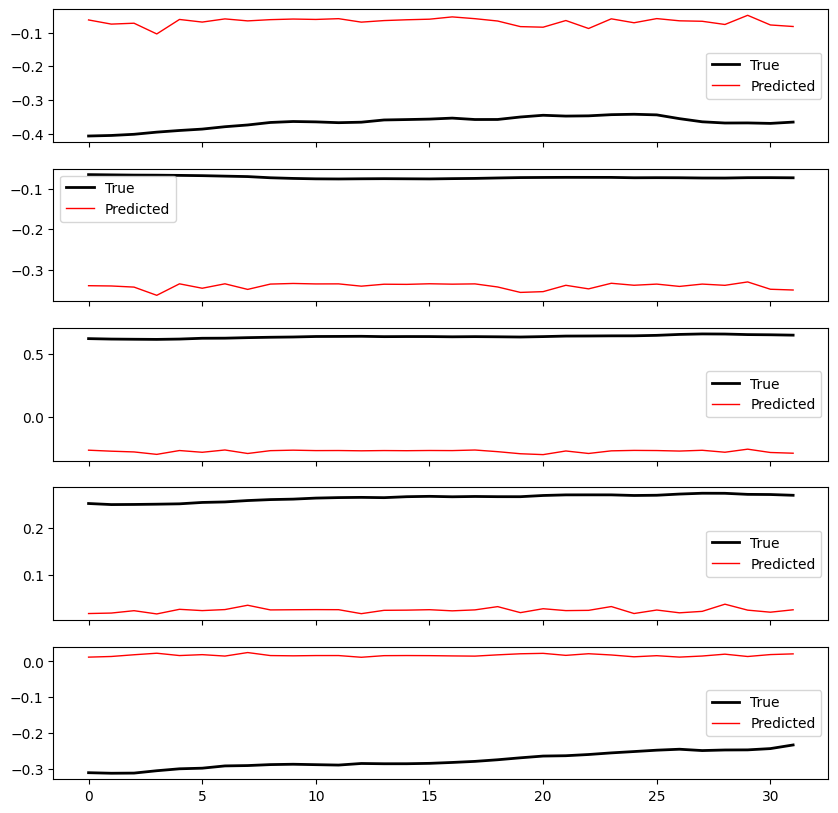

In [44]:
import matplotlib.pyplot as plt


X, Y = train_dataset[0]

Y_hat = model(torch.tensor(X.T).to(device)).detach().cpu().numpy().T

f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_hat[i], label="Predicted", lw=1, color='r')

    ax.legend()


In [45]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from pathlib import Path
from natsort import natsorted
import numpy as np
from safetensors.torch import load_model
import torch 
import pandas as pd

from utils import hvatnet
from utils.creating_dataset import LEFT_TO_RIGHT_HAND


In [86]:
device = 'cpu'
dtype = torch.float32

weights1 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_2_run_fedya\step_150_loss_0.3714.safetensors"

weights2 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_2_run_fedya\step_600_loss_0.3223.safetensors"

weights3 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_2_run_fedya\step_750_loss_0.3100.safetensors"

weights4 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_2_run_fedya\step_3450_loss_0.2758.safetensors"

MODEL_TYPE = 'hvatnet'
model_config = hvatnet.Config(n_electrodes=8, n_channels_out=20,
                            n_res_blocks=3, n_blocks_per_layer=3,
                            n_filters=128, kernel_size=3,
                            strides=(2, 2, 2), dilation=2, 
                            small_strides = (2, 2))
model = hvatnet.HVATNetv3(model_config)


Number of parameters: 4210788


In [79]:

X, Y = test_dataset[1]


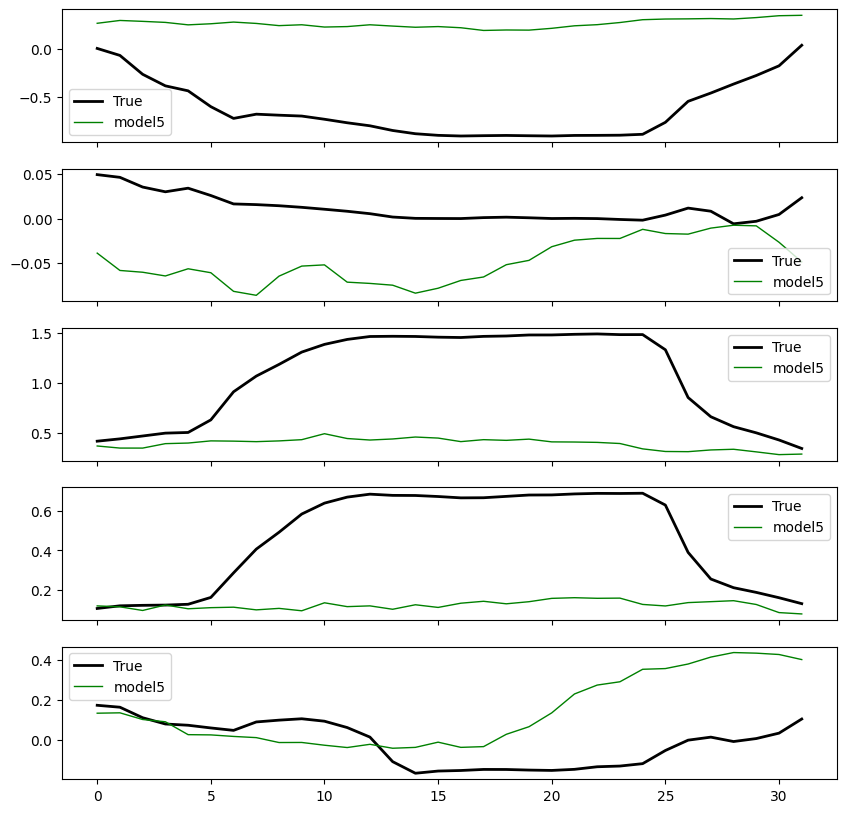

In [84]:
Y_5 = model5(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()

f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_5[i], label="model5", lw=1, color='g')

    ax.legend()


Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788
Number of parameters: 4210788


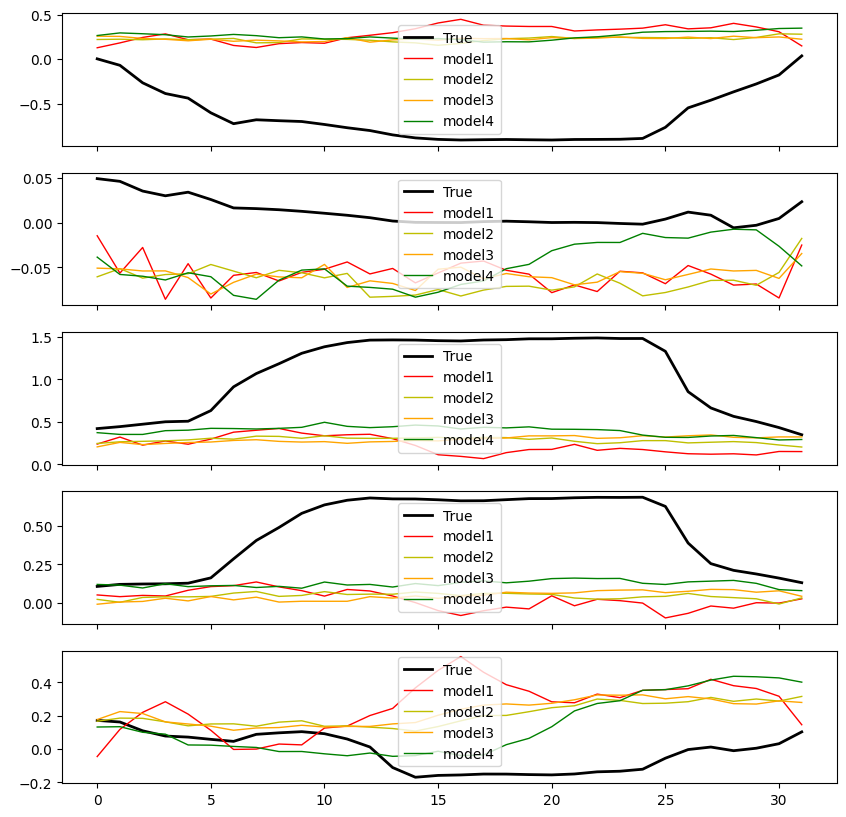

In [89]:

f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')

    model = hvatnet.HVATNetv3(model_config)
    load_model(model, weights1)
    model1 = model.to(device).to(dtype)
    Y_1 = model1(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()    
    ax.plot(Y_1[i], label="model1", lw=1, color='r')

    model = hvatnet.HVATNetv3(model_config)
    load_model(model, weights2)
    model2 = model.to(device).to(dtype)
    Y_2 = model2(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()    
    ax.plot(Y_2[i], label="model2", lw=1, color='y')

    model = hvatnet.HVATNetv3(model_config)
    load_model(model, weights3)
    model3 = model.to(device).to(dtype)
    Y_3 = model3(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()
    ax.plot(Y_3[i], label="model3", lw=1, color='orange')

    model = hvatnet.HVATNetv3(model_config)
    load_model(model, weights4)
    model4 = model.to(device).to(dtype)
    Y_4 = model4(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()
    ax.plot(Y_4[i], label="model4", lw=1, color='g')

    ax.legend()
